## **Autoencoder Greedy Layerwis MLP using MNIST for 500 latent layer**

In [ ]:
####TrainING a 3-hidden layer deep auto encoder in a greedy layerwise fashion; then transfers the encoder weights for initializing
####the corresponding 3-hidden layer MLP

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
input_units = 784      #input− 1024− 500− 1024−output 
hidd1_units= 1024      #number of units in the first hidden layer
output1_units = input_units
nb_classes = 10

###**LOAD DATA SET**

In [ ]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [ ]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

###**DEFNINE AUTOENCODER-1 MODEL ARCHITECTURE**

In [ ]:
#AUTOENCODER-1
ae_model1 = Sequential()
ae_model1.add(Dense(hidd1_units, input_dim=input_units, kernel_initializer='uniform', activation='relu'))
ae_model1.add(Dense(output1_units, activation='sigmoid'))
ae_model1.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

### **TRAIN AUTOENCODER-1**

In [ ]:
ae_model1.fit(X_train, X_train, epochs=1, batch_size=512, shuffle=True)

118/118 [==============================] - 9s 74ms/step - loss: 0.0733 - accuracy: 0.0106


In [ ]:
ae_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
dense_1 (Dense)              (None, 784)               803600    
Total params: 1,607,440
Trainable params: 1,607,440
Non-trainable params: 0
_________________________________________________________________


##**SAVE MODEL-1 WEIGHT**

In [ ]:
ae_model1.save_weights('ae_mnist_1.h5')
ae_model1.load_weights('ae_mnist_1.h5')

In [ ]:
g1=ae_model1.get_config()
h1=ae_model1.get_weights()

In [ ]:
#Note here that enc is hidden layer and dec is output layer
enc1_w= h1[0]
enc1_bias_w= h1[1]
enc1_dec1_w= h1[2]
dec1_bias_w= h1[3]

In [ ]:
#concatenate horizonatlly as array list module1 enc1 and enc1_bias weights
enc1_with_bias_w= [(enc1_w), (enc1_bias_w)]     #keep this for deep model fine-tuning
enc1_w_trans= enc1_w.transpose()    #transpose enc1 weights

In [ ]:
#get shape for enc1 bias from input data size
#Note that by default (originally), input data has samples as rows and attributes as columns
[x1, y1] = np.shape(X_train.transpose())

In [ ]:
#Here, activations computation follow my usual way; y= W(transpose)*x + bias weight*1s
enc1_bias_inp = np.ones((1,y1), dtype= np.int)

In [ ]:
#compute the pre-activations of enc1, including bias contribution
enc1_pre_acts = np.matmul(enc1_w_trans, X_train.transpose()) + np.outer(enc1_bias_w, enc1_bias_inp)

In [ ]:
#Pass enc1 pre-activations through activation function to obtain enc1 activations
#Here list the common activation functions implementation in numpy
#NOTE: use the same activation function used in the pre-training phase of enc1
#ReLU: y= np.maximum(x, 0, x); sigmoid: y= 1 / (1 + np.exp(-x)); tanh: y = np.tanh(x)
enc1_acts= np.maximum(enc1_pre_acts, 0, enc1_pre_acts)  #enc1 activations here

###**DEFNINE AUTOENCODER-2 MODEL**

In [ ]:
#Transpose enc1 activation into Keras original format
ae_model2_input= enc1_acts.transpose()

In [ ]:
hidd1_units

1024

In [ ]:
#Set auto encoder 2 parameters
enc2_input_units = hidd1_units
hidd2_units= 500          #number of units in the second hidden layer
output2_units = enc2_input_units

In [ ]:
output2_units

1024

###**AUTOENCODER-2 MODEL ARCHITECTURE**

In [ ]:
#Define AE_model2 architecture
ae_model2 = Sequential()
ae_model2.add(Dense(hidd2_units, input_dim= enc2_input_units, kernel_initializer='uniform', activation='relu'))
ae_model2.add(Dense(output2_units, activation='sigmoid'))
ae_model2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

### **TRAIN AUTOENCODER-2**

In [ ]:
ae_model2.fit(ae_model2_input, ae_model2_input, epochs=1, batch_size=512, shuffle=True)

118/118 [==============================] - 7s 55ms/step - loss: 0.3552 - accuracy: 1.4232e-04


In [ ]:
ae_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               512500    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              513024    
Total params: 1,025,524
Trainable params: 1,025,524
Non-trainable params: 0
_________________________________________________________________


**SAVE MODEL-2 WEIGHT**

In [ ]:
ae_model2.save_weights('ae_mnist_2.h5')
ae_model2.load_weights('ae_mnist_2.h5')

In [ ]:
g2=ae_model2.get_config()
h2=ae_model2.get_weights()

In [ ]:
#Note here that enc is hidden layer and dec is output layer
enc2_w= h2[0]
enc2_bias_w= h2[1]
enc2_dec2_w= h2[2]
dec2_bias_w= h2[3]

In [ ]:
#concatenate horizonatlly as array list module1 enc and bias weights
enc2_with_bias_w= [(enc2_w), (enc2_bias_w)]     #keep this for deep model fine-tuning

###**DEFINE FINE TUNING MDEL ARCHITECTURE**

In [ ]:
#Finetune(ft) model using encoder weights of trained auto encoder
model_ft = Sequential()
module1_enc_ft_w= [(enc1_w), (enc1_bias_w)]

model_ft.add(Dense(hidd1_units, input_dim=input_units, kernel_initializer='uniform', activation='relu'))
model_ft.layers[0].set_weights(enc1_with_bias_w)

model_ft.add(Dense(hidd2_units, activation='relu'))
model_ft.layers[1].set_weights(enc2_with_bias_w)

model_ft.add(Dense(nb_classes, activation='softmax'))
model_ft.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mse'])

In [ ]:
model_ft.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               512500    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5010      
Total params: 1,321,350
Trainable params: 1,321,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint   
import time

mlp_start = time.time() # for stopwatch
history = model_ft.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_test, y_test),
                            verbose=2, shuffle=True)

mlp_end = time.time()
mlp_took = mlp_end -mlp_start

Epoch 1/5
118/118 - 8s - loss: 0.9033 - accuracy: 0.8274 - mse: 0.0256 - val_loss: 0.1860 - val_accuracy: 0.9457 - val_mse: 0.0083
Epoch 2/5
118/118 - 7s - loss: 0.1502 - accuracy: 0.9572 - mse: 0.0067 - val_loss: 0.1184 - val_accuracy: 0.9669 - val_mse: 0.0053
Epoch 3/5
118/118 - 7s - loss: 0.0996 - accuracy: 0.9715 - mse: 0.0045 - val_loss: 0.0953 - val_accuracy: 0.9709 - val_mse: 0.0044
Epoch 4/5
118/118 - 7s - loss: 0.0750 - accuracy: 0.9783 - mse: 0.0034 - val_loss: 0.0820 - val_accuracy: 0.9758 - val_mse: 0.0038
Epoch 5/5
118/118 - 7s - loss: 0.0562 - accuracy: 0.9837 - mse: 0.0026 - val_loss: 0.0772 - val_accuracy: 0.9775 - val_mse: 0.0035


In [ ]:
print("took %s seconds"%(mlp_took))

took 35.7162344455719 seconds


In [ ]:
print('end of fine-tuning')
train_perf = model_ft.evaluate(X_train, y_train, verbose=0)
test_perf = model_ft.evaluate(X_test, y_test, verbose=0)
print('Train accuracy:', train_perf[1])
print('Test accuracy:', test_perf[1])

end of fine-tuning
Train accuracy: 0.9886333346366882
Test accuracy: 0.9775000214576721


In [ ]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

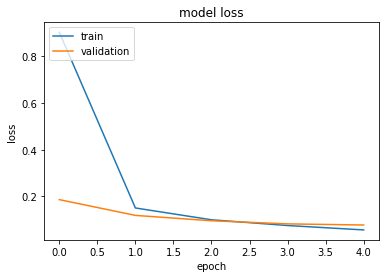

In [ ]:
plotLosses(history)

In [ ]:
score = model_ft.evaluate(X_test, y_test, batch_size=128, verbose=2)

79/79 - 1s - loss: 0.0772 - accuracy: 0.9775 - mse: 0.0035


##**IMAGE RECONSTRUCTION**

In [ ]:
print(model_ft.metrics_names)
print(score)

['loss', 'accuracy', 'mse']
[0.07718072086572647, 0.9775000214576721, 0.0035364441573619843]


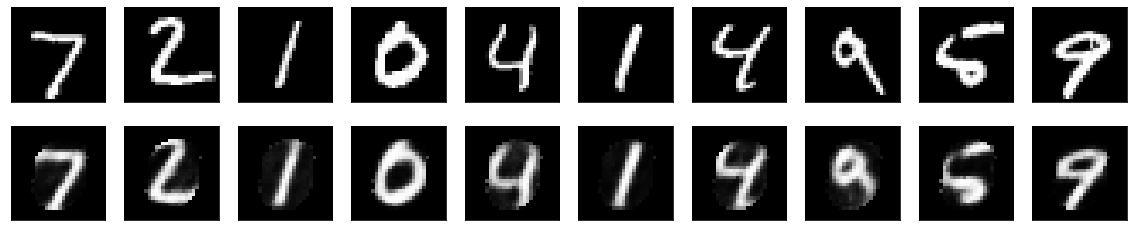

In [ ]:
#Next, let's visualize ten of the input images and the reconstructed outputs from auto encoder module1.
decoded_imgs = ae_model1.predict(X_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #Convert test image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #How many items to display
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##**MEAN SQUARE ERROR**

In [ ]:
from sklearn.metrics import mean_squared_error


MSE = mean_squared_error(X_test, decoded_imgs)
MSE

0.020673841